In [31]:
import pandas as pd
data = pd.read_excel('../附件6-促销期间商家出货量表.xlsx')
ret = []
for i in data['seller_no'].value_counts().index:
    for j in data['warehouse_no'].value_counts().index:
            ret.append(data[(data['seller_no'] == i) & (data['warehouse_no'] == j)])
k = 0
for i in ret:
    for j in i['product_no'].value_counts().index:
        i[(i['product_no'] == j)].sort_values(by = 'date').to_csv(f'time/time{k}.csv', index = False)
        k += 1

In [33]:
import tsfresh
import pandas as pd
import numpy as np
import warnings 
from tsfresh.feature_extraction import MinimalFCParameters
settings = MinimalFCParameters()
warnings.filterwarnings('ignore')
for i in range(1957):
    data = pd.read_csv(f'No_abnormality_time/time{i}.csv')
    data['id'] = i
    if i == 0:
        df = data.copy()
    else:
        df = df.merge(data, how = 'outer', on = df.columns.to_list())
df.loc[:, ['id', 'qty', 'date' ]].to_csv('time.csv', index = False)

In [34]:
from tsfresh.feature_extraction import extract_features
data = pd.read_csv('time.csv')[['id', 'date', 'qty']]
ret = extract_features(data, default_fc_parameters=settings, column_id="id", column_sort="date")
ret.to_csv('time_feature_min.csv', index=False)

Feature Extraction: 100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


In [35]:
import pandas as pd
data = pd.read_csv('time_feature_min.csv')
data2 = pd.read_excel('../附件2-商品信息表.xlsx')
data3 = pd.read_excel('../附件3-商家信息表.xlsx')
data4 = pd.read_excel('../附件4-仓库信息表.xlsx')

for i in range(1956):
    temp = pd.read_csv(f'No_abnormality_time/time{i}.csv')
    v = data3[data3['seller_no'] == temp.iloc[0, 0]]
    for j in ['seller_category', 'inventory_category', 'seller_level']:
        data.loc[i, j] = v[j].values[0]
    v = data2[data2['product_no'] == temp.iloc[0, 1]]
    for j in ['category1', 'category2', 'category3']:
        data.loc[i, j] = v[j].values[0]
    v = data4[data4['warehouse_no'] == temp.iloc[0, 2]]
    for j in ['warehouse _category', 'warehouse _region']:
        data.loc[i, j] = v[j].values[0]

In [36]:
data.to_csv('time_feature_finish.csv', index=False)

In [39]:
import pandas as pd
data_ = pd.read_csv('time_feature_finish.csv')[['qty__standard_deviation', 'qty__mean', 'seller_level', 'warehouse _region', 'category1']]
data_ = pd.get_dummies(data_)

In [40]:
data_ = data_[['qty__standard_deviation', 'qty__mean', 'seller_level_Large',
       'seller_level_Medium', 'seller_level_Small', 'seller_level_Special',
       'warehouse _region_东北', 'warehouse _region_华东', 'warehouse _region_华中',
       'warehouse _region_华北', 'warehouse _region_华南', 'warehouse _region_西北',
       'warehouse _region_西南', 'category1_个人护理', 'category1_传统滋补',
       'category1_厨具', 'category1_宠物生活', 'category1_家具', 'category1_家庭清洁/纸品',
       'category1_家用电器', 'category1_家装建材', 'category1_手机通讯', 'category1_数码',
       'category1_服饰内衣', 'category1_玩具乐器', 'category1_珠宝首饰', 'category1_生活日用',
       'category1_电脑、办公', 'category1_美妆护肤', 'category1_运动户外', 'category1_酒类',
       'category1_食品饮料', 'category1_鲜花/奢侈品']]

In [41]:
import pickle
model = pickle.load(open('K-meas.pkl', 'rb'))
data_['label'] = model.predict(data_)
data_.to_csv('time_cluster.csv', index = False)

In [42]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [48]:
import numpy as np
import pandas as pd
import pickle
labels = pd.read_csv('time_cluster.csv')['label']

index = pd.Series(np.arange(0, 1956))
r = []
for i in range(0, 7):
    ret = []
    for j in index[(labels == i)]:
        data_ = pd.read_csv(f'No_abnormality_time/time{j}.csv')
        n_in = 7
        n_out = 4
        # 将时序数据转换为监督问题数据
        reframed = series_to_supervised(data_.qty.values.reshape(-1, 1), n_in, n_out)    
        
        ret.append(reframed)
    new = pd.concat(ret)
    new['label'] = i
    r.append(new)
_ = pd.get_dummies(pd.concat(r), columns=['label'])
_['promotion'] = True
pickle.dump(_, open(f'timeseries_11.pkl', 'wb'))

In [49]:
import pickle
pickle.load(open(f'timeseries_11.pkl', 'rb'))

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),label_0,label_1,label_2,label_3,label_4,label_5,label_6,promotion
7,136.0,20.0,4.0,7.0,11.0,5.0,3.0,1.0,0.0,4.0,9.0,True,False,False,False,False,False,False,True
7,9.0,8.0,0.0,6.0,4.0,3.0,5.0,3.0,0.0,6.0,10.0,True,False,False,False,False,False,False,True
7,2.0,6.0,8.0,10.0,9.0,1.0,8.0,2.0,3.0,8.0,6.0,True,False,False,False,False,False,False,True
7,9.0,16.0,13.0,7.0,1.0,7.0,2.0,4.0,5.0,8.0,14.0,True,False,False,False,False,False,False,True
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,False,False,False,False,False,False,True,True
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,False,False,False,False,False,False,True,True
7,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,4.0,False,False,False,False,False,False,True,True
7,1.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,3.0,2.0,False,False,False,False,False,False,True,True


In [52]:
import pickle
_f = pickle.load(open(f'timeseries_10.pkl', 'rb'))

In [54]:
pd.concat([_f, _]).to_pickle('timeseries.pkl')

In [57]:
data = pd.read_pickle('timeseries.pkl')

In [58]:
data

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),label_0,label_1,label_2,label_3,label_4,label_5,label_6,promotion
7,2.0,2.0,1.0,0.0,2.0,2.0,4.0,2.0,4.0,4.0,4.0,True,False,False,False,False,False,False,False
8,2.0,1.0,0.0,2.0,2.0,4.0,2.0,4.0,4.0,4.0,7.0,True,False,False,False,False,False,False,False
9,1.0,0.0,2.0,2.0,4.0,2.0,4.0,4.0,4.0,7.0,3.0,True,False,False,False,False,False,False,False
10,0.0,2.0,2.0,4.0,2.0,4.0,4.0,4.0,7.0,3.0,0.0,True,False,False,False,False,False,False,False
11,2.0,2.0,4.0,2.0,4.0,4.0,4.0,7.0,3.0,0.0,1.0,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,False,False,False,False,False,False,True,True
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,False,False,False,False,False,False,True,True
7,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,4.0,False,False,False,False,False,False,True,True
7,1.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,3.0,2.0,False,False,False,False,False,False,True,True


In [59]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import lightgbm
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
data = pd.read_pickle('timeseries.pkl')
y = data.iloc[:, 7:-8].values
x = data.drop(columns=data.iloc[:, 7:-8].columns)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)
model = Pipeline([
    ('scaler', MinMaxScaler()),
    # ('stacking', MultiOutputRegressor(StackingRegressor(
    #     regressors = [
    #         lightgbm.LGBMRegressor(), 
    #         catboost.CatBoostRegressor(), 
    #         #xgboost.XGBRegressor()
            
    #     ], 
    #     meta_regressor=LinearRegression()
    # )))
    #('lightgbm', lightgbm.LGBMRegressor())

    ('lightgbm', MultiOutputRegressor(lightgbm.LGBMRegressor()))
])

model.fit(train_x, train_y)
import numpy as np
def wmapes(y_true, y_pred):
    return 1 - np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1801
[LightGBM] [Info] Number of data points in the train set: 250639, number of used features: 15
[LightGBM] [Info] Start training from score 13.617712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1801
[LightGBM] [Info] Number of data points in the train set: 250639, number of used features: 15
[LightGBM] [Info] Start training from score 13.613219
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [60]:
wmapes(test_y, model.predict(test_x))

0.5716363971338141

In [62]:
import numpy as np
import pandas as pd
import pickle
labels = pd.read_csv('time_cluster.csv')['label']

index = pd.Series(np.arange(0, 1956))
r = []
for i in range(0, 7):
    ret = []
    for j in index[(labels == i)]:
        data_ = pd.read_csv(f'No_abnormality_time/time{j}.csv')
        n_in = 7
        n_out = 0
        # 将时序数据转换为监督问题数据
        reframed = series_to_supervised(data_.qty[-8:].values.reshape(-1, 1), n_in, n_out)    
        reframed['product_no'] = data_['product_no']
        reframed['seller_no'] = data_['seller_no']
        reframed['warehouse_no'] = data_['warehouse_no']
        ret.append(reframed)
    new = pd.concat(ret)
    new['label'] = i
    r.append(new)
pickle.dump(pd.get_dummies(pd.concat(r), columns=['label']).dropna(), open(f'timeseries_test.pkl', 'wb'))


In [7]:

data = pd.read_pickle(f'timeseries_test.pkl')
x = pd.concat([data.iloc[:, :7], data.iloc[:, -7:]], join='outer', axis=1)

In [97]:
pickle.dump(model, open('model.pkl', 'wb'))

In [10]:
ret = []
import pickle
model = pickle.load(open('model.pkl', 'rb'))
for i in range(4):
    x['promotion'] = False
    y_pred = model.predict(x)
    ret.append(y_pred)
    x.iloc[:, :3] = x.iloc[:, 4:7]
    x.iloc[:, 3:7] = y_pred


In [12]:
import numpy as np
np.concatenate(ret, axis=1).shape

(1935, 16)

In [13]:

for i in range(5):
    x['promotion'] = True
    y_pred = model.predict(x)
    ret.append(y_pred)
    x.iloc[:, :3] = x.iloc[:, 4:7]
    x.iloc[:, 3:7] = y_pred

In [19]:
r = []
for i, j in zip(np.concatenate(ret, axis=1), data.iloc[:, 7:10].values):
    _ = pd.DataFrame({'forecast_qty': i[:], 'date': [f'2023/5/{k}' for k in range(16, 32)] + [f'2023/6/{k}' for k in range(1, 21)]})
    _['product_no'] = j[0]
    _['seller_no'] = j[1]
    _['warehouse_no'] = j[2]
    r.append(_)
pd.concat(r)[['seller_no', 'product_no', 'warehouse_no', 'date', 'forecast_qty']].to_excel('结果3-预测结果表_1.xlsx')

In [27]:
import pandas as pd

_ = pd.read_csv(f'../answer1/No_abnormality_time/time{1}.csv', index_col=3)
_p = pd.read_excel('结果3-预测结果表_1.xlsx', index_col=0)
_p = _p[(_p['product_no'] == 'product_121') & (_p['warehouse_no'] == 'wh_1')]

C:\Users\NaClCode\AppData\Local\Temp\ipykernel_23120\1780934139.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([f'2023-05-{i}' for i in range(15, 17)], [_.qty[-1], _p['forecast_qty'].values[0]], 'b')


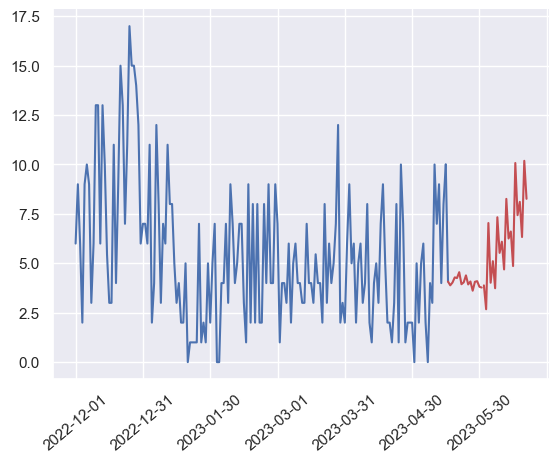

In [32]:
import pylab as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
sns.set(style="darkgrid")
plt.plot(_.index, _.qty, 'b')
plt.plot([f'2023-05-{i}' for i in range(15, 17)], [_.qty[-1], _p['forecast_qty'].values[0]], 'b')
plt.plot([f'2023-05-{i}' for i in range(16, 32)], _p['forecast_qty'].values[:16], 'r')
plt.plot([f'2023-06-{i}' for i in range(1, 21)], _p['forecast_qty'].values[16:], 'r')
plt.xticks(rotation=40)
ax = plt.gca()
sns.despine()
ax.xaxis.set_major_locator(MaxNLocator(steps=[3]))
plt.savefig(fname = '第三问时间序列结果.png', dpi = 500, bbox_inches = 'tight', pad_inches = 0.0)